# Milestone Project 1: Food Vision Big

Source of idea: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

In [2]:
import tensorflow as tf

In [3]:
# Check if tensorflow detects my GPU
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

## Check GPU

For mixed precision training, need to have a GPU of compute capability above 7.0

In [4]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-4db4d962-71a3-5709-c39b-2fda5802e9d6)


## Get Helper functions

In past notebooks, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

In [5]:
# Import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use Tensorflow Datasets to download data

If you want to get an overview of TensorFlow Datasets (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [6]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds


In [7]:
# List all available datasets
datasets_list = tfds.list_builders()
print(datasets_list) # Check if our desired dataset exists or not.

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'amazon_us_reviews', 'anli', 'arc', 'asset', 'assin2', 'bair_robot_pushing_small', 'bccd', 'beans', 'bee_dataset', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'blimp', 'booksum', 'bool_q', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cardiotox', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'cherry_blossoms', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'clic', 'clinc_oos', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco_captions', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'common_voice', 'coqa', 'cos_e', 'cosmos_qa', 'covid19', 'covid19sum', 'crema_d', 'cs_restaurants', 'curated_breast_imaging_ddsm', 'cycle_gan', 'd4rl_adroit_door', 'd4rl_adroit_hammer', 'd4rl_adroit_pen', 'd4rl_adroit_relocate', 'd4rl_ant

In [8]:
# Load in the data (takes 5-6 minutes)
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returne in tuple format (data, label)
                                             with_info=True,
                                             data_dir='C:/Users/adity/TensorFlow_DC_UC/food_101_ds')

## Exploring the Food101 data from Tensorflow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g., are they one-hot encoded or are they label-encoded)
* Do the labels match up with the class names?

In [9]:
# Features of Fod101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [10]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
# Look at trainining data
train_data

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [12]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # Sampoles are in format (image_tesnor, label)

In [13]:
# What does one of our training data look like?
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [14]:
# Output info about our training smaple
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image datatype: {image.dtype}
    Target class from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image shape: (512, 512, 3)
    Image datatype: <dtype: 'uint8'>
    Target class from Food101 (tensor form): 64
    Class name (str form): miso_soup
    


In [15]:
# What does our image tensor look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 43,  89, 125],
        [ 52,  96, 131],
        [ 85, 128, 162],
        ...,
        [251, 254, 223],
        [250, 253, 222],
        [250, 253, 222]],

       [[ 42,  88, 124],
        [ 53,  97, 132],
        [ 92, 135, 169],
        ...,
        [251, 254, 223],
        [250, 253, 222],
        [250, 253, 222]],

       [[ 45,  89, 124],
        [ 52,  96, 131],
        [ 92, 135, 169],
        ...,
        [251, 254, 223],
        [250, 253, 222],
        [250, 253, 222]],

       ...,

       [[ 91,  99,  86],
        [ 89,  97,  84],
        [ 88,  94,  82],
        ...,
        [ 37,  44,  50],
        [ 34,  41,  47],
        [ 31,  38,  44]],

       [[ 91,  99,  86],
        [ 90,  98,  85],
        [ 88,  96,  83],
        ...,
        [ 38,  43,  47],
        [ 35,  40,  44],
        [ 33,  38,  42]],

       [[ 93, 101,  88],
        [ 93, 101,  88],
        [ 89,  97,  84],
        ...,
        [ 37,  42,  4

### Plot an image from TensorFlow Datasets

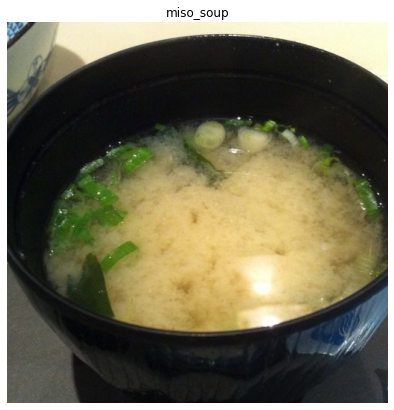

In [16]:
# Plot an image tensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.figure(figsize=(10, 7))
plt.imshow(image)
plt.title(f"{class_names[label.numpy()]}")
plt.axis(False);

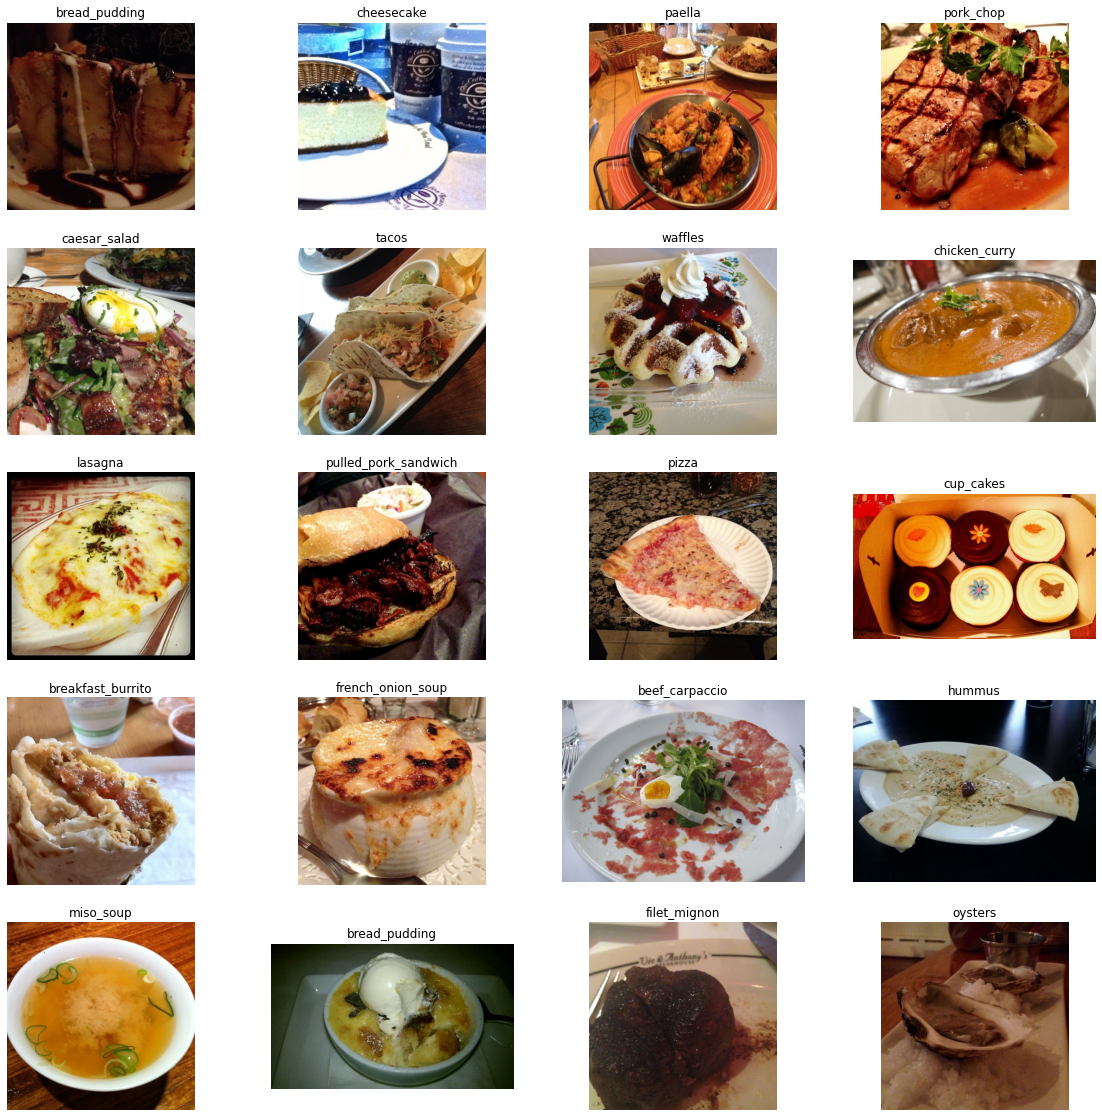

In [17]:
# Function to visualize some random images from the dataset
from factors import *
def plot_random_images(dataset=train_data, figsize=(20, 20), no_of_samples=10):
    """Function to visualize a set of andom images sampled
    dataset.

    Args:
        dataset (<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>, optional): Desired dataset. Defaults to train_data.
        figsize (tuple, optional): Desired figsize. Defaults to (5, 5).
        no_of_samples (int, optional): No. of samples to visualize. Defaults to 10.
    """
    image_tensors = []
    labels = []
    
    # global figure_size
    # if no_of_samples != 10:
    #     figure_size = (int(no_of_samples/2), int(no_of_samples/2))
    # else:
    #     figure_size = figsize
    plt.figure(figsize=figsize)
    samples = dataset.take(no_of_samples)
    for image, label in samples:
        # print(f"""
        # Image shape: {image.shape}
        # Image datatype: {image.dtype}
        # Target class from Food101 (tensor form): {label}
        # Class name (str form): {class_names[label.numpy()]}
        # """)
        image_tensors.append(image)
        labels.append(class_names[label.numpy()])
    for i, j in enumerate(image_tensors):
        plt.subplot(median(factorization(no_of_samples))[0], median(factorization(no_of_samples))[1], i + 1)
        plt.imshow(j)
        plt.title(labels[i])
        plt.axis(False);


plot_random_images(no_of_samples=20)

## Create preprocessing functions for our data

Neural Networks perform best when data is in a certain way (e.g., batched, normalized, etc.).

However, not all data comes like this

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precission `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With those points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from `tf.keras.applications` we don't need to rescale our data (these architecures have rescaling built-in).

This means our function needs to:
1. Reshape our images to all at the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`

In [18]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """Converts image datatype from 'unit8' -> 'float32' and reshapes
    image to [img_shape, img_shape, colour_channels]

    Args:
        image (Tensor): image tensor
        label (int): correspoonding labels
        img_shape (int, optional): Image shape. Defaults to 224.
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape taret image
    return tf.cast(image, tf.float32), label

In [19]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image=image, label=label)[0]

In [20]:
preprocessed_img

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 48.969387,  93.68367 , 129.04082 ],
        [124.78572 , 164.07144 , 195.28572 ],
        [125.37245 , 158.94388 , 183.5153  ],
        ...,
        [251.78574 , 254.78574 , 223.78574 ],
        [251.      , 254.      , 223.      ],
        [250.      , 253.      , 222.      ]],

       [[ 65.28572 , 108.688774, 143.09183 ],
        [129.93878 , 169.09184 , 200.17348 ],
        [ 79.61224 , 115.04081 , 140.88266 ],
        ...,
        [251.78574 , 254.78574 , 223.78574 ],
        [251.      , 254.      , 223.      ],
        [250.      , 253.      , 222.      ]],

       [[ 97.70409 , 140.27551 , 172.56122 ],
        [129.0357  , 168.14795 , 199.09183 ],
        [ 74.      , 111.168365, 138.16837 ],
        ...,
        [251.78574 , 254.78574 , 223.78574 ],
        [251.      , 254.      , 223.      ],
        [250.      , 253.      , 222.      ]],

       ...,

       [[ 88.41836 ,  93.775566,  82.41836 ],
        [ 88.

## Batch & prepare datasets

We're now going to make our data input pipeline run really fast.

For more resources, I'd highly recommend going through the following guide: https://www.tensorflow.org/guide/data

In [21]:
# Map preprocessing function to training(and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function test size (and parallelize)
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle test size and turn into batches and prefetch it
test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

> "Hey, TensorFlow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements at a time and then batch them together and finally make sure you prepare newbatches (prefetch) whilst the model is looking through (finding patterns) the current batch."

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can vsiualize them later if need be)
* ModelCheckpoint Callback

In [23]:
# Create modelcheckpoint callback
checkpoint_path = "model_checkpoint/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training

First and foremost, for a deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model perfomance

In [24]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


## Build feature extraction model

In [25]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional API model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [27]:
for i, layer in enumerate(model.layers):
    print(f"{i} layer: {layer.name}, dtype: {layer.dtype}, mixed_precision_policy: {layer.dtype_policy}")

0 layer: input_layer, dtype: float32, mixed_precision_policy: <Policy "float32">
1 layer: efficientnetb0, dtype: float32, mixed_precision_policy: <Policy "mixed_float16">
2 layer: global_average_pooling2d, dtype: float32, mixed_precision_policy: <Policy "mixed_float16">
3 layer: dense, dtype: float32, mixed_precision_policy: <Policy "mixed_float16">
4 layer: softmax_float32, dtype: float32, mixed_precision_policy: <Policy "float32">


In [28]:
for i, layer in enumerate(model.layers[1].layers):
    print(f"{i} layer: {layer.name}, dtype: {layer.dtype}, mixed_precision_policy: {layer.dtype_policy}")

0 layer: input_1, dtype: float32, mixed_precision_policy: <Policy "float32">
1 layer: rescaling, dtype: float32, mixed_precision_policy: <Policy "mixed_float16">
2 layer: normalization, dtype: float32, mixed_precision_policy: <Policy "float32">
3 layer: stem_conv_pad, dtype: float32, mixed_precision_policy: <Policy "mixed_float16">
4 layer: stem_conv, dtype: float32, mixed_precision_policy: <Policy "mixed_float16">
5 layer: stem_bn, dtype: float32, mixed_precision_policy: <Policy "mixed_float16">
6 layer: stem_activation, dtype: float32, mixed_precision_policy: <Policy "mixed_float16">
7 layer: block1a_dwconv, dtype: float32, mixed_precision_policy: <Policy "mixed_float16">
8 layer: block1a_bn, dtype: float32, mixed_precision_policy: <Policy "mixed_float16">
9 layer: block1a_activation, dtype: float32, mixed_precision_policy: <Policy "mixed_float16">
10 layer: block1a_se_squeeze, dtype: float32, mixed_precision_policy: <Policy "mixed_float16">
11 layer: block1a_se_reshape, dtype: float

Going through the above we see:
* `layer.name`: th human readable name of a particular layer
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model
2. Fine-tune some of the frozen layers

In [29]:
# Fitting the model
history_food_vision_big = model.fit(train_data,
                                    epochs=3,
                                    steps_per_epoch=len(train_data),
                                    validation_data=test_data,
                                    validation_steps=int(0.15 * len(test_data)),
                                    callbacks=[model_checkpoint, create_tensorboard_callback(dir_name="food_vision_tensorboard", experiment_name="model_1")])

Saving TensorBoard log files to: food_vision_tensorboard/model_1/20220206-112240
Epoch 1/3
2368/2368 [==============================] - 115s 45ms/step - loss: 2.3193 - accuracy: 0.4625 - val_loss: 1.2411 - val_accuracy: 0.6748


Epoch 2/3
2368/2368 [==============================] - 109s 46ms/step - loss: 1.3129 - accuracy: 0.6640 - val_loss: 1.1246 - val_accuracy: 0.6986


Epoch 3/3
2368/2368 [==============================] - 110s 46ms/step - loss: 1.1466 - accuracy: 0.7026 - val_loss: 1.0890 - val_accuracy: 0.7076


In [30]:
# Evaluate the model on the whole test dataset
food_vision_big_results = model.evaluate(test_data)

790/790 [==============================] - 35s 43ms/step - loss: 1.0839 - accuracy: 0.7081


In [31]:
# Fine-tuned model
fine_tuned_model = tf.keras.models.load_model('food_vision_big_fine_tuned')

In [32]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=3)

fine_tuned_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                         optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                         metrics=['accuracy'])

In [33]:
saved_model_history = fine_tuned_model.fit(train_data,
                                      epochs=100,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=int(0.15 * len(test_data)),
                                      callbacks=[create_tensorboard_callback('food_vision_tensorboard', 'fine_tune_all_layers_efficientnetb0_logs'), model_checkpoint, earlystopping_callback])

Saving TensorBoard log files to: food_vision_tensorboard/fine_tune_all_layers_efficientnetb0_logs/20220206-112900
Epoch 1/100
2368/2368 [==============================] - 368s 151ms/step - loss: 0.0831 - accuracy: 0.9732 - val_loss: 1.1394 - val_accuracy: 0.7680


Epoch 2/100
2368/2368 [==============================] - 248s 104ms/step - loss: 0.0629 - accuracy: 0.9804 - val_loss: 1.1105 - val_accuracy: 0.7826


Epoch 3/100
2368/2368 [==============================] - 257s 108ms/step - loss: 0.0570 - accuracy: 0.9815 - val_loss: 1.2302 - val_accuracy: 0.7770


Epoch 4/100
2368/2368 [==============================] - 246s 103ms/step - loss: 0.0479 - accuracy: 0.9845 - val_loss: 1.2077 - val_accuracy: 0.7797


Epoch 5/100
2368/2368 [==============================] - 224s 94ms/step - loss: 0.0443 - accuracy: 0.9858 - val_loss: 1.2095 - val_accuracy: 0.7905


Epoch 00005: early stopping


In [34]:
fine_tune_results = fine_tuned_model.evaluate(test_data)

790/790 [==============================] - 24s 30ms/step - loss: 1.2553 - accuracy: 0.7761
